In [8]:
# Goal: Model that determines whether to go long or short based on daily timeframe

import pandas as pd
import numpy as np
from dbConn import engine

data = pd.read_sql_query('''
    SELECT * FROM SPX_full_1day
''', con = engine.connect())

In [39]:
data = data.set_index('Datetime')

In [40]:
data

,Open,High,Low,Close,PrevClose,OpenPct,HighPct,LowPct,ClosePct,T2,GreenDay,RedDay,DaysGreen,DaysRed,Perf5Day
Datetime,,,,,,,,,,,,,,,
2000-11-27,1341.77,1362.50,1341.77,1348.97,NaN,NaN,NaN,NaN,NaN,False,0,0,NaN,NaN,NaN
2000-11-28,1348.97,1358.81,1334.97,1336.09,1348.97,0.000000,0.007294,-0.010378,-0.009548,False,0,1,0.0,0.0,NaN
2000-11-29,1336.09,1352.38,1329.28,1341.93,1336.09,0.000000,0.012192,-0.005097,0.004371,False,1,0,0.0,1.0,NaN
2000-11-30,1341.91,1341.91,1294.90,1314.95,1341.93,-0.000015,-0.000015,-0.035047,-0.020105,False,0,1,1.0,0.0,NaN
2000-12-01,1314.95,1334.67,1307.02,1315.23,1314.95,0.000000,0.014997,-0.006031,0.000213,False,1,0,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,4703.70,4764.54,4699.82,4763.54,4697.24,0.001375,0.014328,0.000549,0.014115,True,1,0,1.0,0.0,-0.001319
2024-01-09,4741.93,4765.47,4730.35,4756.50,4763.54,-0.004537,0.000405,-0.006968,-0.001478,True,0,1,2.0,0.0,0.002882
2024-01-10,4759.94,4790.80,4756.20,4783.45,4756.50,0.000723,0.007211,-0.000063,0.005666,True,1,0,0.0,1.0,0.016715


In [102]:
data['PrevClose'] = data['Close'].shift(1)
data['OpenPct'] = (data['Open'] / data['PrevClose']) - 1
data['HighPct'] = (data['High'] / data['PrevClose']) - 1
data['LowPct'] = (data['Low'] / data['PrevClose']) - 1
data['ClosePct'] = (data['Close'] / data['PrevClose']) - 1
data['GreenDay'] = (data['Close'] > data['PrevClose']) * 1
data['RedDay'] = (data['Close'] <= data['PrevClose']) * 1
data['Perf5Day'] = (data['Close'] / data['Close'].shift(5)) - 1
data['Perf20Day'] = (data['Close'] / data['Close'].shift(20)) - 1

def cumul_sum(col):
        nums = []
        s = 0
        for x in col:
            if x == 1:
                s += 1
            elif x == 0:
                s = 0
            nums.append(s)
        return nums

consec_green = cumul_sum(data['GreenDay'].values)
consec_red = cumul_sum(data['RedDay'].values)

data['DaysGreen'] = consec_green
data['DaysRed'] = consec_red

data['DaysGreen'] = data['DaysGreen'].shift(1)
data['DaysRed'] = data['DaysRed'].shift(1)

In [133]:
# Day after next
data['T2'] = data['Close'].shift(-3) > data['Close']
data['R2'] = (data['Close'].shift(-1) / data['Close']) - 1
# data['T1'] = data['Close'] > data['PrevClose']

In [134]:
final_cols = [
    'OpenPct',
    'HighPct',
    'LowPct',
    'ClosePct',
    'DaysGreen',
    'DaysRed',
    'Perf5Day',
    'Perf20Day'
]

In [135]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.calibration import CalibratedClassifierCV, Ca
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, StandardScaler
import datetime

# Function to convert time string to seconds past midnight
def convert_time_to_seconds(time_series):
    return time_series.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

def apply_convert_time_to_seconds(x):
    return x.apply(convert_time_to_seconds)

time_to_seconds = FunctionTransformer(apply_convert_time_to_seconds, validate=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        (c, StandardScaler(), [c]) for c in final_cols
    ])

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('classifier', LogisticRegression())
    ('classifier', LinearRegression())
    # ('classifier', lgb.LGBMClassifier())
    # ('classifier', CatBoostClassifier())
    # ('classifier', xgb.XGBClassifier())
])

df_use = data.dropna(subset=[
    'Perf20Day',
    'R2'
    ])

# Train the model
X = df_use[final_cols]
y = df_use['R2']

date_idx = int(np.floor(len(X.index.date) * .90))
date_idx_test = int(np.floor(len(X.index.date) * .95))
cutoff_date_val = X.index.date[date_idx]
cutoff_date_test = X.index.date[date_idx_test]
# cutoff_date = '2023-05-31'

X_train = X.loc[:cutoff_date_test]
y_train = y.loc[:cutoff_date_test]
# X_val = X.loc[cutoff_date_val:cutoff_date_test]
# y_val = y_flags.loc[cutoff_date_val:cutoff_date_test]
X_test = X.loc[cutoff_date_test:]
y_test = y.loc[cutoff_date_test:]

ImportError: cannot import name 'Ca' from 'sklearn.calibration' (d:\Projects\session-extrema-model\.venv\lib\site-packages\sklearn\calibration.py)

In [136]:
import joblib
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit

daily_model = pipeline.fit(X_train, y_train)

# calibrator_daily = CalibratedClassifierCV(daily_model, cv=TimeSeriesSplit(n_splits=5))

# daily_model_cv = calibrator_daily.fit(X_train, y_train)

In [137]:
import mlflow
import matplotlib.pyplot as plt

booster = daily_model.named_steps['classifier'].booster_
importance_gain = booster.feature_importance(importance_type='gain')
feature_imp = pd.DataFrame(sorted(zip(importance_gain, X.columns)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=True)

plt.figure(figsize=(20, 10))
plt.barh(feature_imp['Feature'], feature_imp['Value'])
plt.title('HOD Model Features (avg over folds)')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


AttributeError: 'LinearRegression' object has no attribute 'booster_'

In [140]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

preds = daily_model.predict(X_test)

print(mean_absolute_error(y_test, preds))
print(mean_squared_error(y_test, preds, squared=False))


0.009841308193874628
0.012399761477204924


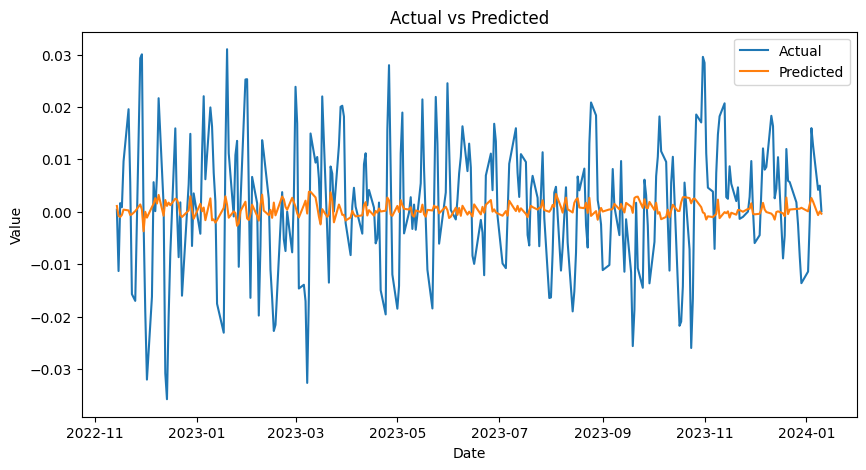

In [141]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, preds, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [128]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, brier_score_loss

# Metrics for HOD model
y_pred = daily_model.predict_proba(X_test)[:,-1]

roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred > 0.5)
recall = recall_score(y_test, y_pred > 0.5)
brier_score = brier_score_loss(y_test, y_pred)

print(f"ROC AUC Score: {roc_auc}")
print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"Brier Score: {brier_score}")

train_start = X_train.index.date.min()
train_end = X_train.index.date.max()
test_start = X_test.index.date.min()
test_end = X_test.index.date.max()
train_size = len(X_train)
test_size = len(X_test)

AttributeError: 'LinearRegression' object has no attribute 'predict_proba'

In [116]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, brier_score_loss

# Metrics for HOD model
y_pred_cv = daily_model_cv.predict_proba(X_test)[:,-1]

roc_auc_cv = roc_auc_score(y_test, y_pred_cv)
precision_cv = precision_score(y_test, y_pred_cv > 0.5)
recall_cv = recall_score(y_test, y_pred_cv > 0.5)
brier_score_cv = brier_score_loss(y_test, y_pred_cv)

print(f"ROC AUC Score: {roc_auc_cv}")
print(f"Precision Score: {precision_cv}")
print(f"Recall Score: {recall_cv}")
print(f"Brier Score: {brier_score_cv}")

ROC AUC Score: 0.5320515917105453
Precision Score: 0.5620689655172414
Recall Score: 1.0
Brier Score: 0.24582120032075283


In [84]:
y_test.mean()

0.5876288659793815

In [85]:
y_train.mean()

0.5538656527249683

(array([ 4.,  6., 22., 44., 86., 64., 33., 18.,  7.,  7.]),
 array([0.51310857, 0.52189823, 0.53068789, 0.53947754, 0.5482672 ,
        0.55705686, 0.56584652, 0.57463617, 0.58342583, 0.59221549,
        0.60100515]),
 <BarContainer object of 10 artists>)

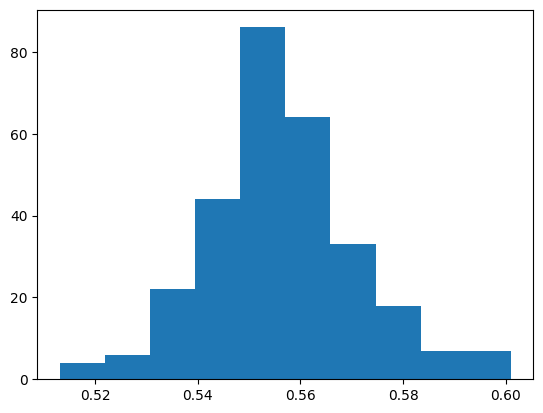

In [86]:
plt.hist(y_pred)

(array([ 5., 17., 45., 74., 79., 32., 23., 11.,  4.,  1.]),
 array([0.55213679, 0.55541172, 0.55868664, 0.56196157, 0.5652365 ,
        0.56851142, 0.57178635, 0.57506127, 0.5783362 , 0.58161113,
        0.58488605]),
 <BarContainer object of 10 artists>)

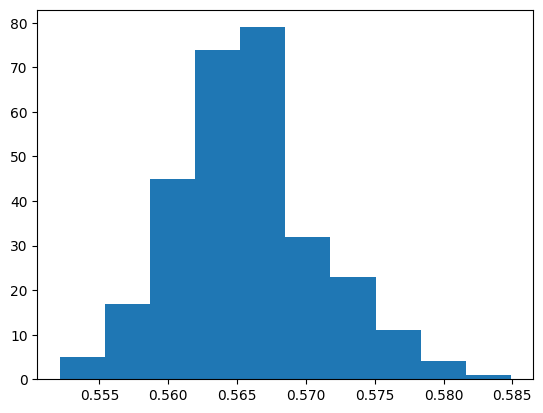

In [87]:
plt.hist(y_pred_cv)